In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from tqdm import tqdm
import shutil
import json
from datetime import datetime
from osgeo import gdal

In [30]:
country_list = ["BR_A001", "NZ_A001", "NZ_A002", "US_A001", "ZA_A001"]
wv_list = ["WV01", "WV02", "WV03"]
countries_dict = {}

for country in country_list:
    perfect = 0
    nocloud = 0
    total = 0
    if country not in countries_dict:
        countries_dict[country] = []

    for wv in wv_list:
        image_folder_path = "../data/" + country + '/Image/' + wv + '/'
        for item in os.listdir(image_folder_path):
            if item.endswith(".tif"):
                # image path
                image_path = image_folder_path + item
                total += 1

                file_name = item.split("-")[-1]
                mask_folder_path = image_folder_path.replace("Image", "Mask") + '/' + file_name.replace(".tif", '/')
                for mask in os.listdir(mask_folder_path):
                    if len(mask) == 22 and mask.startswith("Occlusion"):
                        # mask path
                        mask_path = mask_folder_path + mask
                
                # metadata path
                metadata_path = image_path.replace("Image", "Metadata").replace(".tif", ".json")

                with open(metadata_path, 'r') as f:
                    metadata = json.load(f)
                    cloud_cover = metadata['cloud_cover']
                    nodata_fraction = metadata['nodata_fraction']
                    acquisition_time = metadata['acquisition_time']['isoformat']
                    acquisition_time = datetime.fromisoformat(acquisition_time)

                    if cloud_cover == 0:
                        nocloud += 1
                    if cloud_cover == 0 and nodata_fraction < 1e-7:
                        perfect += 1

                        occluded_mask = gdal.Open(mask_path).ReadAsArray()
                        occluded_ratio = np.sum(occluded_mask[occluded_mask==1]) / (occluded_mask.shape[0] * occluded_mask.shape[1])

                        countries_dict[country].append(
                            {"image_path": image_path,
                             "mask_path": mask_path,
                             "acquisition_date": acquisition_time,
                             "occluded_ratio": occluded_ratio,
                             })

    print(country + ' -- nocloud number: ' + str(nocloud))
    print(country + ' -- satisfied number: ' + str(perfect))
    print('percentage: '+ str(round(perfect/total*100,5))+ '%, with total number: '+ str(total))


BR_A001 -- nocloud number: 80
BR_A001 -- satisfied number: 58
percentage: 19.72789%, with total number: 294
NZ_A001 -- nocloud number: 131
NZ_A001 -- satisfied number: 81
percentage: 25.0774%, with total number: 323
NZ_A002 -- nocloud number: 118
NZ_A002 -- satisfied number: 82
percentage: 26.7101%, with total number: 307
US_A001 -- nocloud number: 106
US_A001 -- satisfied number: 92
percentage: 32.97491%, with total number: 279
ZA_A001 -- nocloud number: 80
ZA_A001 -- satisfied number: 51
percentage: 28.1768%, with total number: 181


In [32]:
base_dir = '../pro_data/'
for country, data in countries_dict.items():
    if country == "BR_A001":
        continue
    
    if os.path.exists(base_dir + country):
        shutil.rmtree(base_dir + country)
    os.makedirs(base_dir + country + '/image/')
    os.makedirs(base_dir + country + '/mask/')

    sorted_data = sorted(data, key=lambda x: x['occluded_ratio'], reverse=True)
    top_masks = sorted_data[:6]
    if top_masks[-1]['occluded_ratio'] > 0.025:
        for i in range(6, len(sorted_data)):
            if sorted_data[i]['occluded_ratio'] > 0.025:
                top_masks.append(sorted_data[i])
            else:
                break

    for item in data:
        if item['occluded_ratio'] < 0.01:
            shutil.copy(item['image_path'], base_dir + country + '/image/' + os.path.basename(item['image_path']))
    
    for item in top_masks:
        shutil.copy(item['mask_path'], base_dir + country + '/mask/'+ os.path.basename(item['image_path']).replace(".tif", "_mask.tif"))

## Mask values and pixel numbers of each image

In [14]:
## write mask statistics into mask_stat.txt


country_list = ["BR_A001", "NZ_A001", "NZ_A002", "US_A001", "ZA_A001"]
# country_list = ["BR_A001"]

for country_folder in country_list:
        mask_folder = "../data/" + country_folder + "/Mask"
        for wv_ in os.listdir(mask_folder): # WV01, WV02, WV03
                
            with open("mask_stat/"+country_folder+"_"+wv_+"_mask_stat.txt", "w") as f:
                
                wv_folder = mask_folder + "/" + wv_
                for file_folder in os.listdir(wv_folder):
                    for mask in os.listdir(wv_folder + "/" + file_folder):

                        if mask.startswith("ShadowMask") and len(mask)==19:
                        # if mask.startswith("OcclusionMask") and len(mask)==22:

                            mask_path = wv_folder + "/" + file_folder + "/" + mask
                            mask_tif = Image.open(mask_path)
                            mask_tif = np.array(mask_tif)
                            unique, counts = np.unique(mask_tif, return_counts=True)
                            
                            # get number of all pixels
                            total = mask_tif.shape[0] * mask_tif.shape[1]

                            #write file_folder, counts, total into mask_stat.txt, with , as separator
                            f.write(file_folder + ", " + ', '.join(str(num) for num in counts) + ", " + str(total) + "\n")

                            # print(file_folder, unique, counts)

In [6]:
## read mask statistics from mask_stat.txt, create all_data dictionary and plot histogram

country_list = ["BR_A001", "NZ_A001", "NZ_A002", "US_A001", "ZA_A001"]
satellite_list = ["WV01", "WV02", "WV03"]

all_nodata = []
all_num = 0
all_data = {}

# country level
for country_folder in country_list:
        country_num = 0
        wv_num = []
        country_nodata = []

        # satellite level
        for wv_ in satellite_list:
                # read mask_stat.txt line by line as a list with separator ,
                wv_nodata = []

                with open("mask_stat/"+country_folder+"_"+wv_+"_mask_stat.txt", "r") as f:
                        lines = f.readlines()
                        wv_num.append(len(lines))

                        for line in lines:
                                line = line.split(", ")
                                file = line[0]

                                total = line[-1]
                                nodata_percentage = int(line[-2]) / int(total) * 100
                                wv_nodata.append(nodata_percentage)

                                # create a dictionary with key as file name and value as nodata percentage
                                if file not in all_data:
                                        all_data[file] = []
                                all_data[file].append({"country": country_folder, "satellite": wv_, "nodata_percentage": nodata_percentage})
                
                country_nodata.extend(wv_nodata)
                country_num += len(lines)

        # print info in satellite level
        for i in range(len(wv_num)):
                print(country_folder + " with " + satellite_list[i] + " -- image number: " + str(wv_num[i]))

        all_num += country_num
        all_nodata.extend(country_nodata)

        # print info in country level
        print(country_folder + " -- total image number: " + str(country_num))

print("Total number of images: " + str(all_num))

BR_A001 with WV01 -- image number: 49
BR_A001 with WV02 -- image number: 180
BR_A001 with WV03 -- image number: 65
BR_A001 -- total image number: 294
NZ_A001 with WV01 -- image number: 80
NZ_A001 with WV02 -- image number: 161
NZ_A001 with WV03 -- image number: 82
NZ_A001 -- total image number: 323
NZ_A002 with WV01 -- image number: 96
NZ_A002 with WV02 -- image number: 143
NZ_A002 with WV03 -- image number: 68
NZ_A002 -- total image number: 307
US_A001 with WV01 -- image number: 95
US_A001 with WV02 -- image number: 167
US_A001 with WV03 -- image number: 17
US_A001 -- total image number: 279
ZA_A001 with WV01 -- image number: 27
ZA_A001 with WV02 -- image number: 98
ZA_A001 with WV03 -- image number: 56
ZA_A001 -- total image number: 181
Total number of images: 1384


1384


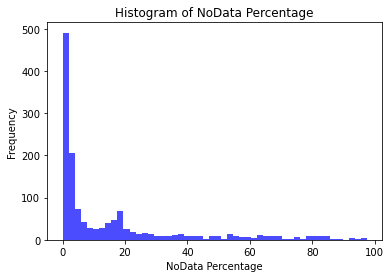

In [7]:
print(len(all_nodata))

# plot histogram
plt.hist(all_nodata, bins=50, alpha=0.7, color='b')
plt.xlabel('NoData Percentage')
plt.ylabel('Frequency')
plt.title('Histogram of NoData Percentage')
plt.show()

In [7]:
## rename images and construct image folder

# get the image name, split the name with - and get the last part
# copy and paste the image to another folder and rename

country_list = ["BR_A001", "NZ_A001", "NZ_A002", "US_A001", "ZA_A001"]
satellite_list = ["WV01", "WV02", "WV03"]

for country in country_list:
    for wv in satellite_list:
        image_folder_path = "../data/" + country + "/" + wv
        for file in os.listdir(image_folder_path):
            if file.endswith(".tif"):
                image_source_path = image_folder_path + "/" + file

                file_name = file.split("-")[-1]
                image_destination_path = "../data/" + country + "/Image/" + wv + "/" + file_name
                shutil.copyfile(image_source_path, image_destination_path)
                

## Find the smallest nodata ratio image and the largest ratio mask

In [10]:
# print(all_data) 

# find the smallest nodata percentage and its corresponding country and satellite
min_nodata = 100
min_country = ""
min_satellite = ""
for file in all_data:
        for data in all_data[file]:
                if data["nodata_percentage"] < min_nodata:
                        min_nodata = data["nodata_percentage"]
                        min_country = data["country"]
                        min_satellite = data["satellite"]
print("The smallest nodata percentage is " + str(min_nodata) + " in " + min_country + " with " + min_satellite)

{'014886600010_01_P002': [{'country': 'BR_A001', 'satellite': 'WV01', 'nodata_percentage': 5.343545110452261}], '014886625010_01_P001': [{'country': 'BR_A001', 'satellite': 'WV01', 'nodata_percentage': 15.391947455190655}], '014886625010_01_P002': [{'country': 'BR_A001', 'satellite': 'WV01', 'nodata_percentage': 66.05861894126514}], '014886630010_01_P005': [{'country': 'BR_A001', 'satellite': 'WV01', 'nodata_percentage': 9.096553357880719}], '014886654010_01_P005': [{'country': 'BR_A001', 'satellite': 'WV01', 'nodata_percentage': 23.382539610063468}], '014886671010_01_P001': [{'country': 'BR_A001', 'satellite': 'WV01', 'nodata_percentage': 11.225618389947757}], '014886671010_01_P002': [{'country': 'BR_A001', 'satellite': 'WV01', 'nodata_percentage': 68.01244960400787}], '014886672010_01_P001': [{'country': 'BR_A001', 'satellite': 'WV01', 'nodata_percentage': 17.946097004948687}], '014886672010_01_P002': [{'country': 'BR_A001', 'satellite': 'WV01', 'nodata_percentage': 58.38303023397388

In [7]:
## find the largest and smallest nodata percentage in each country

country_list = ["BR_A001", "NZ_A001", "NZ_A002", "US_A001", "ZA_A001"]
img_list = []
img_sate_list = []
mask_list = []
mask_sate_list = []

for country in country_list:
        min_nodata = 100
        max_nodata = 0
        threashold = 40   # set a threashold to filter out the nodata percentage that is too large
        min_satellite = ""
        max_satellite = ""
        min_file = ""
        max_file = ""

        for file in all_data:
                for data in all_data[file]:
                        if data["country"] == country:
                                if data["nodata_percentage"] < min_nodata:
                                        min_nodata = data["nodata_percentage"]
                                        min_satellite = data["satellite"]
                                        min_file = file
                                
                                if data["nodata_percentage"] > max_nodata and data["nodata_percentage"] < threashold:
                                        max_nodata = data["nodata_percentage"]
                                        max_satellite = data["satellite"]
                                        max_file = file



        img_list.append(min_file)
        img_sate_list.append(min_satellite)
        mask_list.append(max_file)
        mask_sate_list.append(max_satellite)

        print("The smallest nodata percentage in " + country + " is " + str(min_nodata) + " with " + min_satellite)
        print("The largest nodata percentage in " + country + " is " + str(max_nodata) + " with " + max_satellite)

The smallest nodata percentage in BR_A001 is 0.6309067534631974 with WV03
The largest nodata percentage in BR_A001 is 39.93905558304212 with WV03
The smallest nodata percentage in NZ_A001 is 0.08555780001040347 with WV02
The largest nodata percentage in NZ_A001 is 39.829070319345846 with WV03
The smallest nodata percentage in NZ_A002 is 0.0027489109840469683 with WV02
The largest nodata percentage in NZ_A002 is 39.67705422904095 with WV03
The smallest nodata percentage in US_A001 is 0.017950536676927763 with WV01
The largest nodata percentage in US_A001 is 37.8904402479289 with WV01
The smallest nodata percentage in ZA_A001 is 0.013849496448278738 with WV02
The largest nodata percentage in ZA_A001 is 38.63522271769206 with WV02


In [22]:
print(img_list)
print(img_sate_list)
print(mask_list)
print(mask_sate_list)

['014862788010_01_P001', '014422040010_01_P002', '014422040010_01_P002', '011875955010_01_P001', '014905009010_01_P004']
['WV03', 'WV02', 'WV02', 'WV01', 'WV02']
['014893064010_01_P002', '014422084010_01_P003', '014771232010_01_P001', '014422443010_01_P006', '014905494010_01_P001']
['WV03', 'WV03', 'WV03', 'WV01', 'WV02']


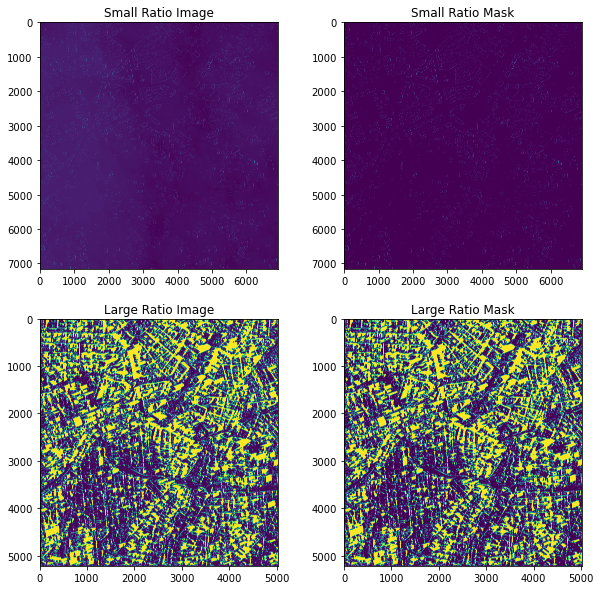

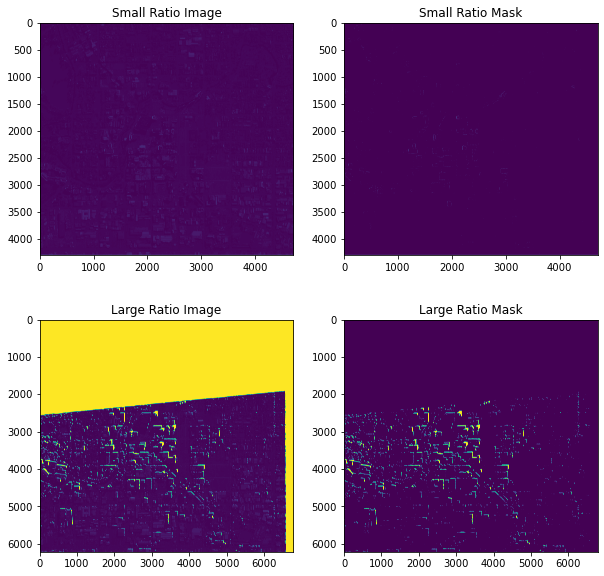

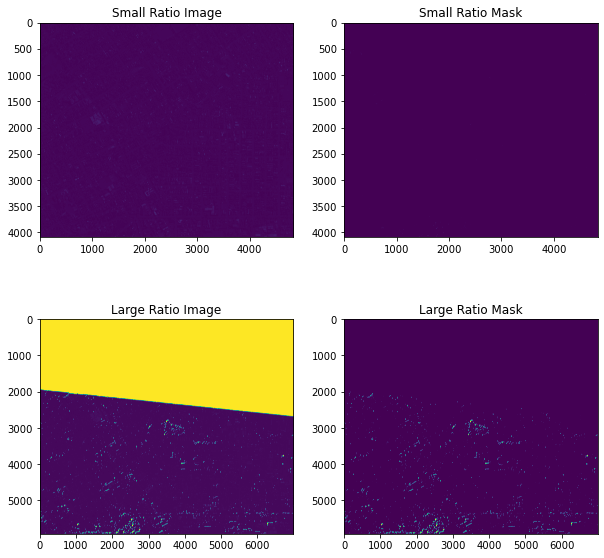

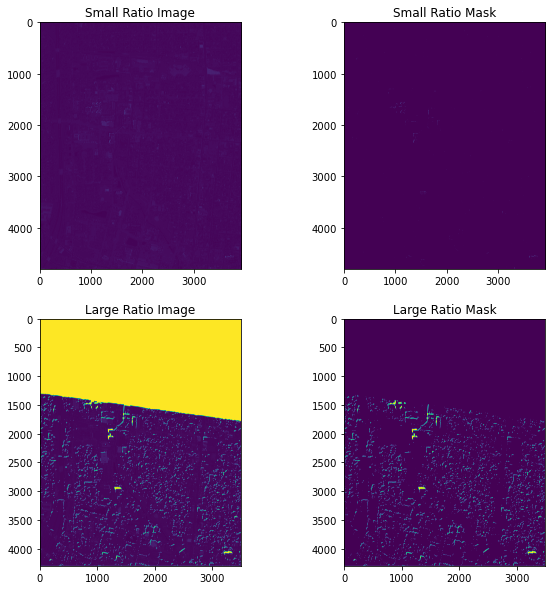

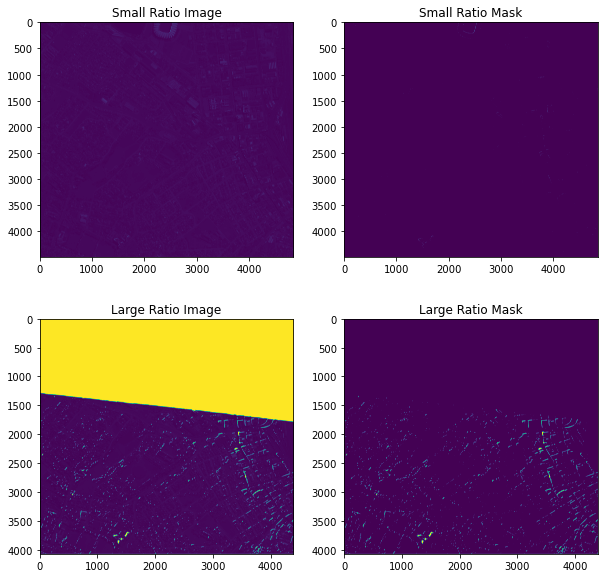

In [20]:
# show the those images and occlusion masks

country_list = ["BR_A001", "NZ_A001", "NZ_A002", "US_A001", "ZA_A001"]
for i in range(len(img_list)):
      country = country_list[i]

      # small ratio image and corresponding mask
      small_img_path = "../data/" + country + "/Image/" + img_sate_list[i] + "/" + img_list[i] + ".tif"
      for file in os.listdir("../data/" + country + "/Mask/" + img_sate_list[i] + "/" + img_list[i]):
            if file.startswith("OcclusionMask") and len(file)==22:
                  small_mask_path = "../data/" + country + "/Mask/" + img_sate_list[i] + "/" + img_list[i] + "/" + file
      
      # large ratio image and corresponding mask
      large_img_path = "../data/" + country + "/Image/" + mask_sate_list[i] + "/" + mask_list[i] + ".tif"
      for file in os.listdir("../data/" + country + "/Mask/" + mask_sate_list[i] + "/" + mask_list[i]):
            if file.startswith("OcclusionMask") and len(file)==22:
                  large_mask_path = "../data/" + country + "/Mask/" + mask_sate_list[i] + "/" + mask_list[i] + "/" + file
      
      # plot image and corresponding mask in a row, while small ratio image and mask in the first row, large ratio image and mask in the second row
      fig, ax = plt.subplots(2, 2, figsize=(10, 10))
      ax[0, 0].imshow(Image.open(small_img_path))
      ax[0, 0].set_title('Small Ratio Image')
      ax[0, 1].imshow(Image.open(small_mask_path))
      ax[0, 1].set_title('Small Ratio Mask')
      ax[1, 0].imshow(Image.open(large_img_path))
      ax[1, 0].set_title('Large Ratio Image')
      ax[1, 1].imshow(Image.open(large_mask_path))
      ax[1, 1].set_title('Large Ratio Mask')
      plt.show()



## Prepare test data

Text(0.5, 1.0, 'Large Ratio Mask')

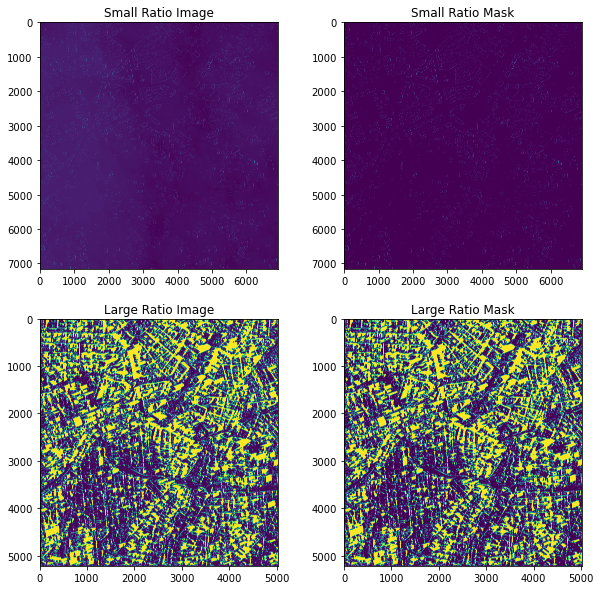

In [8]:
# get test image and mask

country_list = ["BR_A001"]
for i in range(len(img_list)):
      country = country_list[i]


      ####################################################################
      ####################################################################
      ## find the small ratio image and large ratio mask for test data and copy them to another folder

      # small_img_path = "../data/" + country + "/Image/" + img_sate_list[i] + "/" + img_list[i] + ".tif"

      # for file in os.listdir("../data/" + country + "/Mask/" + mask_sate_list[i] + "/" + mask_list[i]):
      #       if file.startswith("OcclusionMask") and len(file)==22:
      #             large_mask_path = "../data/" + country + "/Mask/" + mask_sate_list[i] + "/" + mask_list[i] + "/" + file
      #             break
                  
      # print(small_img_path)
      # print(large_mask_path)

      # # copy the small ratio image and large ratio mask to another folder "/scratch2/ziyliu/LAMA/lama/test_img"
      # shutil.copyfile(small_img_path, "/scratch2/ziyliu/LAMA/lama/test_img/" + img_list[i] + ".tif")
      # shutil.copyfile(large_mask_path, "/scratch2/ziyliu/LAMA/lama/test_img/" + file)
      ####################################################################
      ####################################################################

      # small ratio image and corresponding mask
      small_img_path = "../data/" + country + "/Image/" + img_sate_list[i] + "/" + img_list[i] + ".tif"
      for file in os.listdir("../data/" + country + "/Mask/" + img_sate_list[i] + "/" + img_list[i]):
            if file.startswith("OcclusionMask") and len(file)==22:
                  small_mask_path = "../data/" + country + "/Mask/" + img_sate_list[i] + "/" + img_list[i] + "/" + file
      
      # large ratio image and corresponding mask
      large_img_path = "../data/" + country + "/Image/" + mask_sate_list[i] + "/" + mask_list[i] + ".tif"
      for file in os.listdir("../data/" + country + "/Mask/" + mask_sate_list[i] + "/" + mask_list[i]):
            if file.startswith("OcclusionMask") and len(file)==22:
                  large_mask_path = "../data/" + country + "/Mask/" + mask_sate_list[i] + "/" + mask_list[i] + "/" + file

      break

# show the test image and mask
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(Image.open(small_img_path))
ax[0, 0].set_title('Small Ratio Image')
ax[0, 1].imshow(Image.open(small_mask_path))
ax[0, 1].set_title('Small Ratio Mask')
ax[1, 0].imshow(Image.open(large_img_path))
ax[1, 0].set_title('Large Ratio Image')
ax[1, 1].imshow(Image.open(large_mask_path))
ax[1, 1].set_title('Large Ratio Mask')
    

In [40]:
# show the size of the test image and mask
from osgeo import gdal

test_image = gdal.Open(small_img_path)
test_mask = gdal.Open(large_mask_path)

geotransform = test_image.GetGeoTransform()
image_x_res = geotransform[1]  # pixel resolution in horizon direction
image_y_res = abs(geotransform[5])  # pixel resolution in vertical direction

print('image spatial information:')
print(f'pixel spatial width: {image_x_res} meters')
print(f'pixel spatial height: {image_y_res} meters')
print(f"x size: {test_image.RasterXSize}, y size: {test_image.RasterYSize}")
print("actual image size: ", test_image.RasterXSize * image_x_res, test_image.RasterYSize * image_y_res)
print("\n")

geotransform = test_mask.GetGeoTransform()
mask_x_res = geotransform[1]  # pixel resolution in horizon direction
mask_y_res = abs(geotransform[5])  # pixel resolution in vertical direction

print('mask spatial information:')
print(f'pixel spatial width: {mask_x_res} meters')
print(f'pixel spatial height: {mask_y_res} meters')
print(f"x size: {test_mask.RasterXSize}, y size: {test_mask.RasterYSize}")
print("actual mask size: ", test_mask.RasterXSize * mask_x_res, test_mask.RasterYSize * mask_y_res)

image spatial information:
pixel spatial width: 0.3100904668909514 meters
pixel spatial height: 0.3100904668909514 meters
x size: 6904, y size: 7171
actual image size:  2140.8645834151284 2223.6587380750125


mask spatial information:
pixel spatial width: 0.42640756920130723 meters
pixel spatial height: 0.42640756920130723 meters
x size: 5021, y size: 5215
actual mask size:  2140.9924049597635 2223.7154733848174


In [1]:
# print the verison of python
import sys
print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [12]:
# copy and pastes the test image and mask to another folder
shutil.copyfile(small_img_path, "/scratch2/ziyliu/LAMA/lama/euler_files/" + "image.tif")
shutil.copyfile(large_mask_path, "/scratch2/ziyliu/LAMA/lama/euler_files/" + "mask.tif")

'/scratch2/ziyliu/LAMA/lama/euler_files/mask.tif'

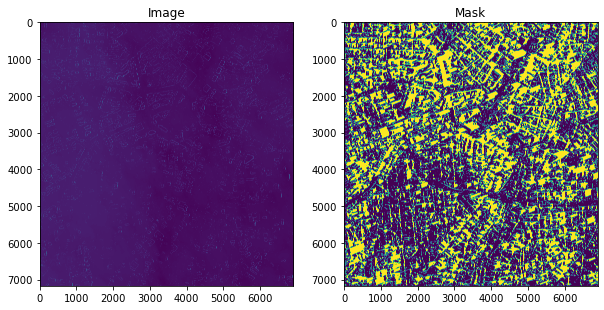

In [9]:
image = Image.open(small_img_path)
mask = Image.open(large_mask_path)

# resize the mask to the same size as the image
# target_size = (min(test_image.RasterXSize, test_mask.RasterXSize), min(test_image.RasterYSize, test_mask.RasterYSize))
# image = image.resize(target_size, Image.ANTIALIAS)  ##--------------'image' has the wrong mode-----------------##
# mask = mask.resize(target_size, Image.ANTIALIAS)
mask = mask.resize(image.size, Image.ANTIALIAS)

# show image and mask
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title('Image')
ax[1].imshow(mask)
ax[1].set_title('Mask')
plt.show()

# # save the image and mask as .png to another folder
# image.save("/scratch2/ziyliu/LAMA/lama/test_img/image.png")
# mask.save("/scratch2/ziyliu/LAMA/lama/test_img/mask.png")

Text(0.5, 1.0, 'Resized Mask')

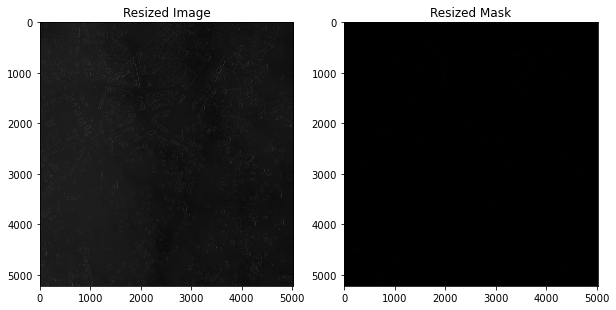

In [41]:
# # resize the test image and mask to the same size
# import cv2

# # read the image and mask
# image = cv2.imread(small_img_path)
# mask = cv2.imread(large_mask_path)

# # use the smaller width and height as the new size
# target_size = (min(test_image.RasterXSize, test_mask.RasterXSize), min(test_image.RasterYSize, test_mask.RasterYSize))

# # resize the image and mask to the same size
# image = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
# mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_LINEAR)

# # show the resized image and mask
# fig, ax = plt.subplots(1, 2, figsize=(10, 10))
# ax[0].imshow(image)
# ax[0].set_title('Resized Image')
# ax[1].imshow(mask)
# ax[1].set_title('Resized Mask')

### trials

image value range:  0 65535
mask value range:  0 1


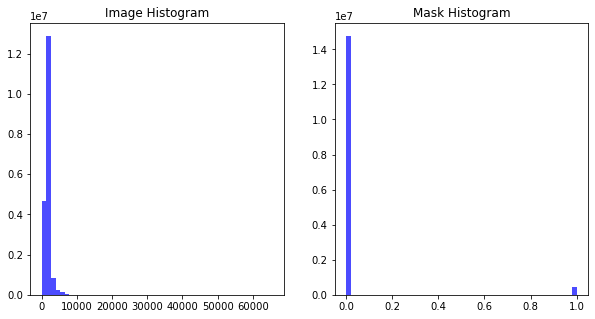

In [4]:
image = Image.open("/scratch2/ziyliu/LAMA/lama/014905040010_01_P001.tif")
mask = Image.open("/scratch2/ziyliu/LAMA/lama/OcclusionMask-56cm.tif")

# print the value range of the image and mask
image = np.array(image)
mask = np.array(mask)

print("image value range: ", np.min(image), np.max(image))
print("mask value range: ", np.min(mask), np.max(mask))

# plot the histogram of the image and mask
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(image.flatten(), bins=50, alpha=0.7, color='b')
ax[0].set_title('Image Histogram')
ax[1].hist(mask.flatten(), bins=50, alpha=0.7, color='b')
ax[1].set_title('Mask Histogram')
plt.show()


In [5]:
image = Image.open("/scratch2/ziyliu/LAMA/lama/014905040010_01_P001.tif")
mask = Image.open("/scratch2/ziyliu/LAMA/lama/OcclusionMask-56cm.tif")

# resize the mask to the same size as the image
# target_size = (min(test_image.RasterXSize, test_mask.RasterXSize), min(test_image.RasterYSize, test_mask.RasterYSize))
# image = image.resize(target_size, Image.ANTIALIAS)  ##--------------image has the wrong mode-----------------##
# mask = mask.resize(target_size, Image.ANTIALIAS)
mask = mask.resize(image.size, Image.ANTIALIAS)


# set the size of the patch
patch_size = 512

image_size = image.size

patch_test = []
for i in range(1):
        # select the bottom right corner of the patch
        x = image_size[0] - patch_size
        y = image_size[1] - patch_size

        # cut the patch from the image and mask
        patch_image = image.crop((x, y, x+patch_size, y+patch_size))
        patch_mask = mask.crop((x, y, x+patch_size, y+patch_size))

        # set value 1 in mask as 255
        patch_mask = np.array(patch_mask)
        patch_mask[patch_mask==1] = 255
        patch_mask = Image.fromarray(patch_mask)

        # save the patch as .png to another folder
        patch_image.save("/scratch2/ziyliu/LAMA/lama/test_img/image2.tif")
        patch_mask.save("/scratch2/ziyliu/LAMA/lama/test_img/image2_mask001.tif")


### patch and its pixel value histogram

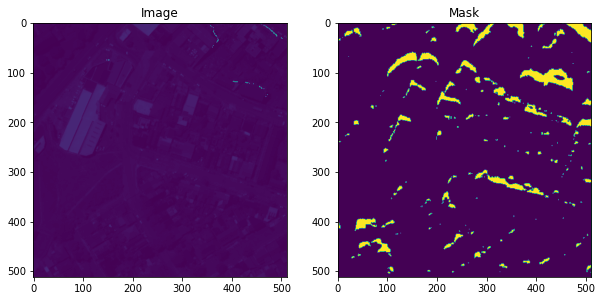

In [2]:
patch_image = Image.open("/scratch2/ziyliu/LAMA/lama/test_img/image2.tif")
patch_mask = Image.open("/scratch2/ziyliu/LAMA/lama/test_img/image2_mask001.tif")

# show image and mask
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(patch_image)
ax[0].set_title('Image')
ax[1].imshow(patch_mask)
ax[1].set_title('Mask')
plt.show()

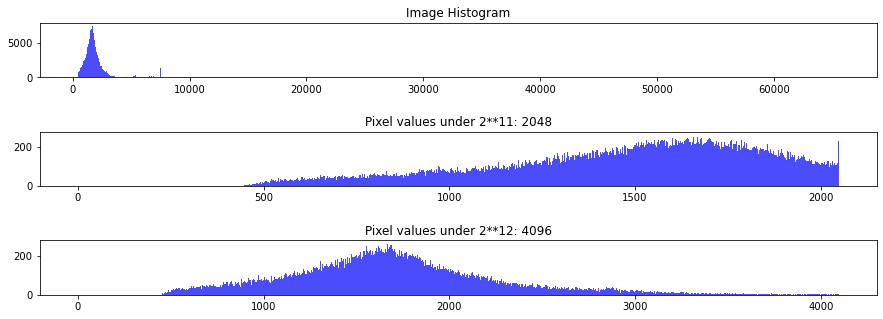

In [18]:
# plot the histogram of the pixel values of patch (part of the image)
patch_image = np.array(patch_image)

fig, ax = plt.subplots(3, 1, figsize=(15, 5))
ax[0].hist(patch_image.flatten(), bins=2048, alpha=0.7, color='b')
ax[1].hist(patch_image.flatten(), bins=2048, range=(0, 2048), alpha=0.7, color='b')
ax[2].hist(patch_image.flatten(), bins=4096, range=(0, 4096), alpha=0.7, color='b')
# set title 
ax[0].set_title('Image Histogram')
ax[1].set_title('Pixel values under 2**11: 2048')
ax[2].set_title('Pixel values under 2**12: 4096')
plt.subplots_adjust(hspace=1) 
plt.show()

min value:  379.9512802250322 
max value:  2526.6355078557817


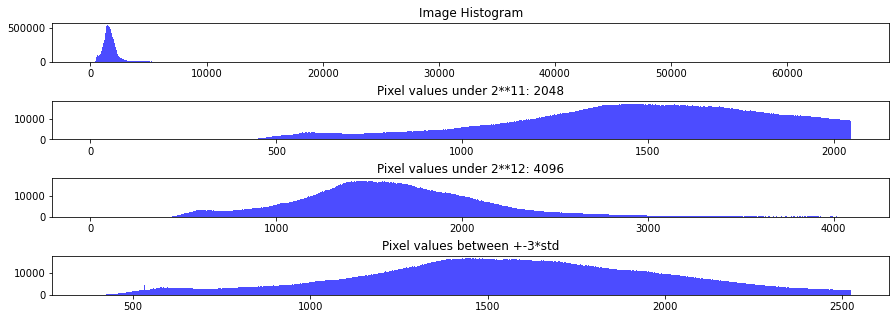

In [10]:
patch_image = Image.open("/scratch2/ziyliu/LAMA/lama/euler_files/014905040010_01_P001.tif")
# plot the histogram of the pixel values of image
patch_image = np.array(patch_image)

mu = np.mean(patch_image[patch_image < 2048])
std = np.std(patch_image[patch_image < 2048])
min_value = mu - 3 * std
max_value = mu + 3 * std
print('min value: ', min_value, '\nmax value: ', max_value)

fig, ax = plt.subplots(4, 1, figsize=(15, 5))
ax[0].hist(patch_image.flatten(), bins=2048, alpha=0.7, color='b')
ax[1].hist(patch_image.flatten(), bins=2048, range=(0, 2048), alpha=0.7, color='b')
ax[2].hist(patch_image.flatten(), bins=4096, range=(0, 4096), alpha=0.7, color='b')
ax[3].hist(patch_image.flatten(), bins=int(max_value-min_value), range=(min_value, max_value), alpha=0.7, color='b')
# ax[4].hist(patch_image.flatten(), bins=int(max_value), range=(0, max_value), alpha=0.7, color='b')
# set title 
ax[0].set_title('Image Histogram')
ax[1].set_title('Pixel values under 2**11: 2048')
ax[2].set_title('Pixel values under 2**12: 4096')
ax[3].set_title('Pixel values between +-3*std')
# ax[4].set_title('Pixel values under 3*std')
plt.subplots_adjust(hspace=1) 
plt.show()

In [7]:
from scipy.stats import shapiro

patch_image = patch_image.flatten()

print('< 2048:')
filtered_patch_image = patch_image[patch_image<2048]
# 使用Shapiro-Wilk测试检查像素值的正态性
stat, p = shapiro(filtered_patch_image)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# 解释
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

print('< 4096:')
filtered_patch_image = patch_image[patch_image<4096]
# 使用Shapiro-Wilk测试检查像素值的正态性
stat, p = shapiro(filtered_patch_image)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# 解释
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

print('< 3200:')
filtered_patch_image = patch_image[patch_image<3200]
# 使用Shapiro-Wilk测试检查像素值的正态性
stat, p = shapiro(filtered_patch_image)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# 解释
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

print('< 3std:')
filtered_patch_image = patch_image[patch_image<=max_value]
filtered_patch_image = filtered_patch_image[filtered_patch_image>=min_value]
# 使用Shapiro-Wilk测试检查像素值的正态性
stat, p = shapiro(filtered_patch_image)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# 解释
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

print('>= 0 & < 3std:')
filtered_patch_image = patch_image[patch_image<=max_value]
# 使用Shapiro-Wilk测试检查像素值的正态性
stat, p = shapiro(filtered_patch_image)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# 解释
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

< 2048:
Statistics=0.882, p=0.000
Sample does not look Gaussian (reject H0)
< 4096:
Statistics=0.959, p=0.000
Sample does not look Gaussian (reject H0)
< 3200:
Statistics=0.970, p=0.000
Sample does not look Gaussian (reject H0)
< 3std:
Statistics=1.033, p=1.000
Sample looks Gaussian (fail to reject H0)
>= 0 & < 3std:
Statistics=0.969, p=0.000
Sample does not look Gaussian (reject H0)


In [11]:
filtered_patch_image = patch_image[patch_image<=max_value]
filtered_patch_image = filtered_patch_image[filtered_patch_image>=min_value]

mu_ = np.mean(filtered_patch_image)
std_ = np.std(filtered_patch_image)
print('min value: ', mu_ - 3 * std_, '\nmax value: ', mu_ + 3 * std_)
# do the min and max change after filtering the pixel values because some are filtered out

min value:  275.3960851362533 
max value:  2833.052888803829


## tif info in QGIS and python code check

In [2]:
## with RasterIO.py from ImpliCity github
file_path="/scratch2/ziyliu/LAMA/lama/euler_files/014905040010_01_P001.tif"

# import functions from the file
from RasterIO import RasterReader
import numpy as np

raster_reader = RasterReader(file_path)
data = raster_reader.get_data(band=1)

unique, counts = np.unique(data, return_counts=True)
print(np.asarray((unique, counts)).T)

[[    0     4]
 [   81     1]
 [  167     1]
 ...
 [ 9329     1]
 [ 9405     1]
 [65535  4266]]


In [2]:
## use gdal to read the image
from osgeo import gdal
import numpy as np
file_path="/scratch2/ziyliu/LAMA/lama/euler_files/014905040010_01_P001.tif"

dataset = gdal.Open(file_path)
print(dataset.GetMetadata())
# print the min and max value of the image
print(dataset.GetRasterBand(1).ComputeRasterMinMax())
# print the nodata value of the image
print(dataset.GetRasterBand(1).GetNoDataValue())
print(dataset.ReadAsArray().dtype)

dataset_array = dataset.ReadAsArray()
unique, counts = np.unique(dataset_array, return_counts=True)
print(np.asarray((unique, counts)).T)


{'AREA_OR_POINT': 'Area'}
(0.0, 9405.0)
65535.0
uint16
[[    0     4]
 [   81     1]
 [  167     1]
 ...
 [ 9329     1]
 [ 9405     1]
 [65535  4266]]


### saved tif with / without metadata check

In [22]:
# use rasterio to read the image
file_path="/scratch2/ziyliu/LAMA/lama/euler_files/014905040010_01_P001.tif"
new_file_path1="/scratch2/ziyliu/LAMA/lama/euler_files/saved_img_withmeta.tif"
new_file_path2="/scratch2/ziyliu/LAMA/lama/euler_files/saved_img_nometa.tif"

import rasterio
import numpy as np

with rasterio.open(file_path) as src:
    data = src.read()
    profile = src.profile
print(data.shape)
unique, counts = np.unique(data, return_counts=True)
print(np.asarray((unique, counts)).T)

# with metadata
with rasterio.open(new_file_path1, 'w', **profile) as dst:
    dst.write(data)

# without metadata
import PIL.Image as Image
Image.fromarray(data[0]).save(new_file_path2)

(1, 4177, 4507)
[[    0     4]
 [   81     1]
 [  167     1]
 ...
 [ 9329     1]
 [ 9405     1]
 [65535  4266]]


In [23]:
with rasterio.open(new_file_path1) as src:
    data = src.read()
    print(src.profile)
print(data.shape)
unique, counts = np.unique(data, return_counts=True)
print(np.asarray((unique, counts)).T)

with rasterio.open(new_file_path2) as src:
    data = src.read()
    print(src.profile)
print(data.shape)
unique, counts = np.unique(data, return_counts=True)
print(np.asarray((unique, counts)).T)

# with != without, with = original

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 65535.0, 'width': 4507, 'height': 4177, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unknown",GEOGCS["unknown",DATUM["Unknown_based_on_WGS84_ellipsoid",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Oblique_Stereographic"],PARAMETER["latitude_of_origin",-33.9470042367929],PARAMETER["central_meridian",25.5996312642643],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(0.5044175766791915, 0.0, -1146.0012968718295,
       0.0, -0.5044175766791915, 1046.9970989015512), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
(1, 4177, 4507)
[[    0     4]
 [   81     1]
 [  167     1]
 ...
 [ 9329     1]
 [ 9405     1]
 [65535  4266]]
{'driver': 'GTiff',

/usr/lib/python3/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


[[    0     4]
 [   81     1]
 [  167     1]
 ...
 [ 9329     1]
 [ 9405     1]
 [65535  4266]]


In [4]:
# use rasterio to read the image
file_path="/scratch2/ziyliu/LAMA/lama/euler_files/014905040010_01_P001.tif"

import rasterio
import numpy as np

with rasterio.open(file_path) as src:
    data = src.read()
    print(src.profile)

mask_path = "/scratch2/ziyliu/LAMA/lama/euler_files/OcclusionMask-56cm.tif"
with rasterio.open(mask_path) as src:
    mask = src.read()
    print(src.profile)
unique, counts = np.unique(mask, return_counts=True)
print(np.asarray((unique, counts)).T)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 65535.0, 'width': 4507, 'height': 4177, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unknown",GEOGCS["unknown",DATUM["Unknown_based_on_WGS84_ellipsoid",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Oblique_Stereographic"],PARAMETER["latitude_of_origin",-33.9470042367929],PARAMETER["central_meridian",25.5996312642643],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(0.5044175766791915, 0.0, -1146.0012968718295,
       0.0, -0.5044175766791915, 1046.9970989015512), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 4050, 'height': 3753, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unkn

In [1]:
# use rasterio to read the image
file_path="/scratch2/ziyliu/LAMA/lama/euler_files/014905040010_01_P001.tif"

import rasterio
import numpy as np

with rasterio.open(file_path) as src:
    profile = src.profile

mask_path = "/scratch2/ziyliu/LAMA/lama/test_img_output/count.tif"
with rasterio.open(mask_path) as src:
    mask = src.read()

with rasterio.open("/scratch2/ziyliu/LAMA/lama/test_img_output/count_metadata.tif", 'w', **profile) as dst:
    dst.write(mask)

/usr/lib/python3/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
